In [1]:
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.cluster import hierarchy
from scipy.spatial import distance

%matplotlib inline  

In [2]:
%run ../diff/chipseq_diff_plots.py

In [3]:
path = "/mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff"

output_path = "/mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed"

diffs_dict = {}

for mark in ['H3K27ac', 'H3K27me3', 'H3K4me1', 'H3K4me3', 'H3K36me3']:
    print(mark)
    out = os.path.join(output_path, mark)

    if os.path.exists(out):
        shutil.rmtree(out)
        os.mkdir(out)

    diffs = DiffProcessor(path, out, mark)
    diffs.collect_difference()
    
    diffs_dict[mark] = diffs 

H3K27ac
H3K27me3
H3K4me1
H3K4me3
H3K36me3


## H3K27ac

In [4]:
diffs = diffs_dict['H3K27ac']

In [5]:
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_span_H3K27ac_dedup_TRUE_f_125_DBA_...,1,0,1
1,diff_bind_cons_span_H3K27ac_dedup_TRUE_f_125...,1,0,1
2,chipdiff_H3K27ac,0,0,0
3,diff_OD_YD_H3K27ac_span_200_0.01_0,45324,42941,2383
4,diff_OD_YD_H3K27ac_span_200_0.01_5,41288,39038,2250
5,diff_OD_YD_H3K27ac_span_200_0.01_10,38633,36467,2166
6,diff_OD_YD_H3K27ac_span_200_1.0E-4_0,2192,2157,35
7,diff_OD_YD_H3K27ac_span_200_1.0E-4_5,2049,2016,33
8,diff_OD_YD_H3K27ac_span_200_1.0E-4_10,1998,1965,33
9,diff_OD_YD_H3K27ac_span_200_1.0E-6_0,113,110,3


In [6]:
intersection = diffs.count_intersections()

/tmp/tmp6rdp4_l9.tmp


In [7]:
def do_plot(metrics="jaccard", subset=None):
    matplotlib.rcParams['figure.figsize'] = (12,12)
    names = [n[:-9] for n in diffs.get_bed_files_produced()]
    
    files = diffs.get_bed_files_produced()
    
    if subset is not None:
        names = [n[:-9] for n in subset]
        files = subset

    sz = len(names)
    aa = np.zeros((sz, sz))

    for i1, f1 in enumerate(files):
        if (subset is not None) and (f1 not in subset):
            continue
        for i2, f2 in enumerate(files):
            if (subset is not None) and (f2 not in subset):
                continue
            if i1 == i2:
                aa[i1, i2] = 1.0
                continue
            t1 = intersection[(f1, f1)]
            t2 = intersection[(f2, f2)]
            i = intersection[(f1, f2)]
            
            if metrics=="jaccard":
                if (t1 + t2 - i) > 0:
                    aa[i1, i2] = i / (t1 + t2 - i)
                else:
                    aa[i1, i2] = 0.0
            else:
                if t1 > 0:
                    aa[i1, i2] = i / t1
                else:
                    aa[i1, i2] = 0.0
            
    if metrics=="jaccard":
        dissimilarity = distance.squareform(1 - aa)
        linkage = hierarchy.linkage(dissimilarity, method="single")    
        g = sns.clustermap(aa, row_linkage=linkage, col_linkage=linkage, cmap="rainbow", yticklabels=names)
    else:
        g = sns.clustermap(aa, cmap="rainbow", xticklabels=names, yticklabels=names)


    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)  # For y axis
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90) # For x axis

    plt.show()

In [8]:
def get_tool(name):
    if 'diff_bind' in name:
        return 'diff_bind'
    
    if 'diff_macs_pooled_Y_O' in name:
        return 'diff_macs_pooled_Y_O'
    
    if 'diff_macs_pooled' in name:
        return 'diff_macs_pooled'
    
    if 'median_consensus' in name:
        return 'median_consensus'
    
    if 'diffReps' in name:
        return 'diffReps'
    
    if 'span' in name:
        return 'span'
    
    return name

In [9]:
def print_best(metrics="jaccard"):
    names = [n[:-4] for n in diffs.get_bed_files_produced()]

    best = {}

    for f1 in diffs.get_bed_files_produced():
        for f2 in diffs.get_bed_files_produced():
            tool1 = get_tool(f1)
            tool2 = get_tool(f2)
            
            if tool1 == tool2: 
                continue
                
            if metrics=="jaccard" and tool1 > tool2:
                continue
            
            t1 = intersection[(f1, f1)]
            t2 = intersection[(f2, f2)]
            i = intersection[(f1, f2)]
            
            if metrics=="jaccard":
                if (t1 + t2 - i) > 0:
                    score = i / (t1 + t2 - i)
                else:
                    score = 0.0
            else:
                if t1 > 0:
                    score = i / t1
                else:
                    score = 0.0
                    
            if tool1 not in best:
                best[tool1] = {}
                        
            best1 = best[tool1]
            
            if tool2 not in best1:
                best1[tool2] = (None, None, -1)
            current = best1[tool2][2]
    
            if score > current:
                best1[tool2] = (f1, f2, score)
    
    data = []
    
    for tool1 in best:
        for tool2 in best[tool1]:
            f1, f2, score = best[tool1][tool2]
            data.append((f1, f2, score))
            
    s = sorted(data, key=lambda item: -item[2])    
    
    return pd.DataFrame.from_records(s, columns=["f1", "f2", "score"])

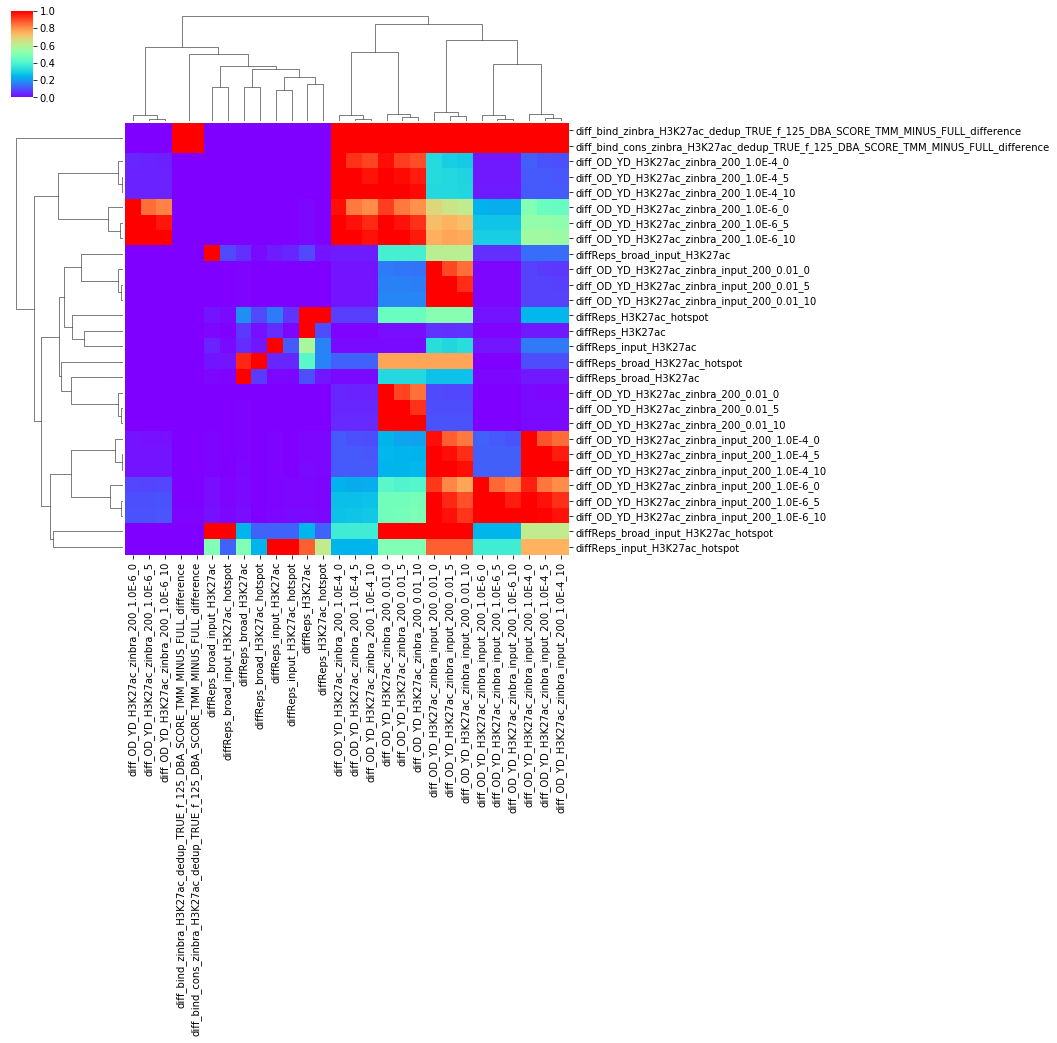

In [10]:
do_plot("m1")

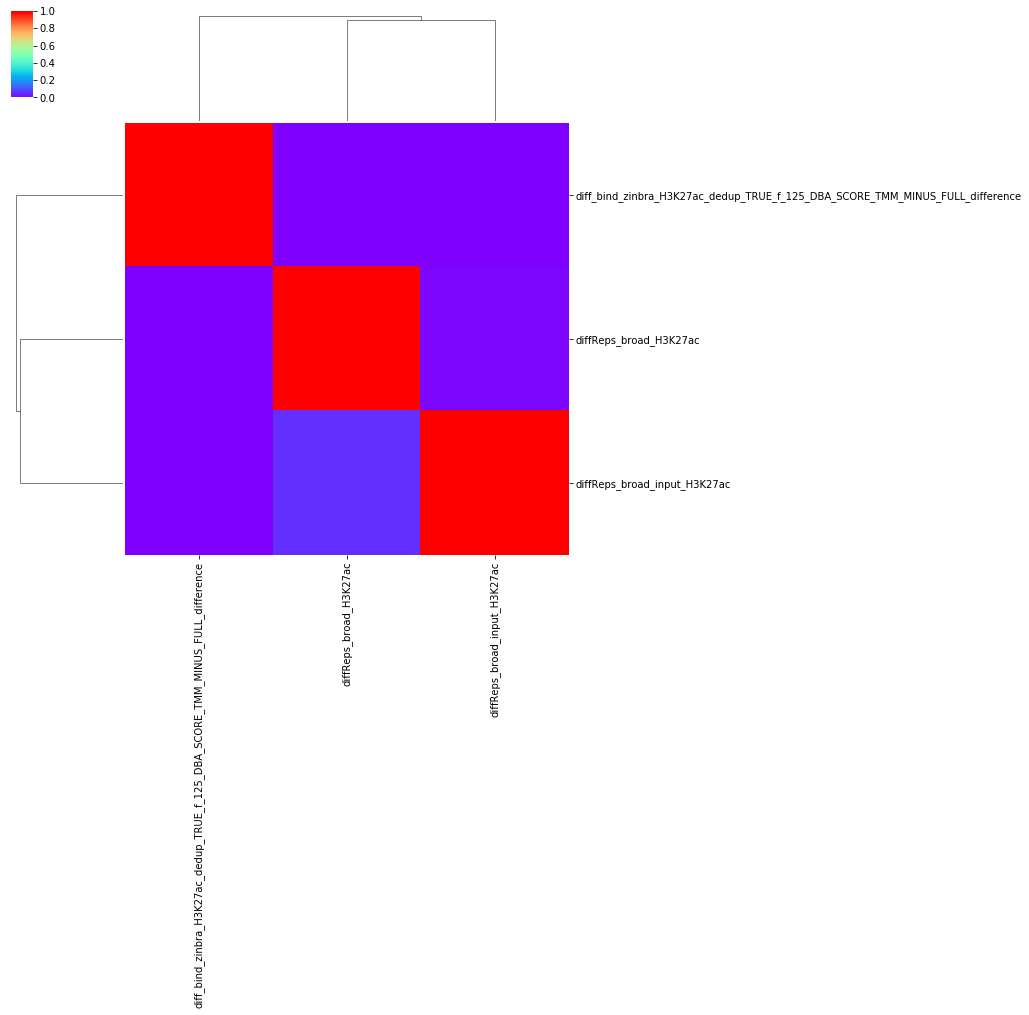

In [11]:
do_plot("m1", [
    "diff_bind_span_H3K27ac_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed",            
    "diffReps_broad_H3K27ac_both.bed",
    "diffReps_broad_input_H3K27ac_both.bed"])

In [12]:
print_best("jaccard")

,f1,f2,score
0,diffReps_broad_input_H3K27ac_both.bed,diff_OD_YD_H3K27ac_span_input_200_1.0E-6_10_...,0.014970
1,diff_bind_span_H3K27ac_dedup_TRUE_f_125_DBA_...,diff_OD_YD_H3K27ac_span_input_200_1.0E-6_10_...,0.003937
2,diffReps_H3K27ac_both.bed,diff_bind_span_H3K27ac_dedup_TRUE_f_125_DBA_...,0.000000


bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27ac/both/diffReps_H3K27ac_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27ac/both/diffReps_input_H3K27ac_both.bed >/tmp/tmpkk85tajy.tmp/counts.bed
0


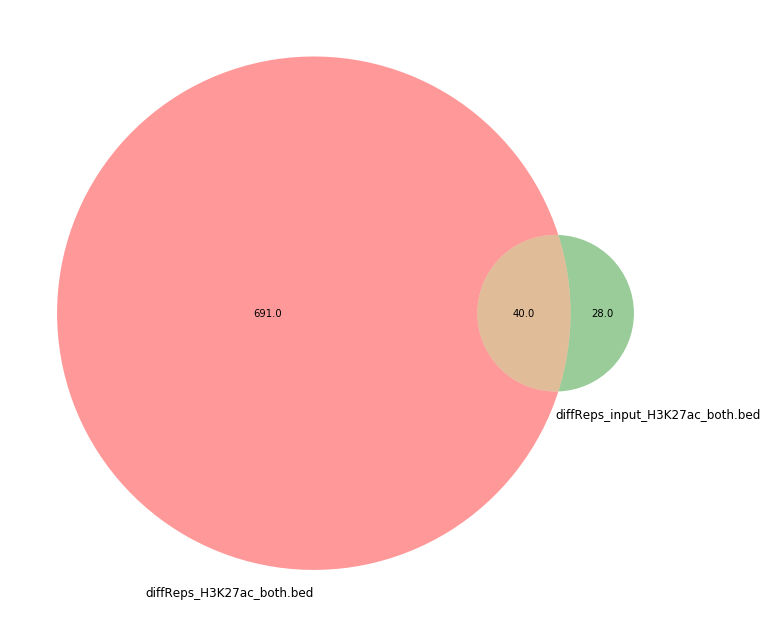

In [13]:
diffs.plot_venn2('diffReps_H3K27ac_both.bed', 
                 'diffReps_input_H3K27ac_both.bed')

# H3K27me3

In [14]:
diffs = diffs_dict['H3K27me3']

In [15]:
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_span_H3K27me3_dedup_TRUE_f_125_DBA...,3,1,2
1,diff_bind_cons_span_H3K27me3_dedup_TRUE_f_12...,1,0,1
2,chipdiff_H3K27me3,0,0,0
3,diff_OD_YD_H3K27me3_span_200_0.01_0,20002,16576,3426
4,diff_OD_YD_H3K27me3_span_200_0.01_5,19349,16001,3348
5,diff_OD_YD_H3K27me3_span_200_0.01_10,18991,15692,3299
6,diff_OD_YD_H3K27me3_span_200_1.0E-4_0,141,138,3
7,diff_OD_YD_H3K27me3_span_200_1.0E-4_5,141,138,3
8,diff_OD_YD_H3K27me3_span_200_1.0E-4_10,141,138,3
9,diff_OD_YD_H3K27me3_span_200_1.0E-6_0,0,0,0


/tmp/tmpasslzhg3.tmp


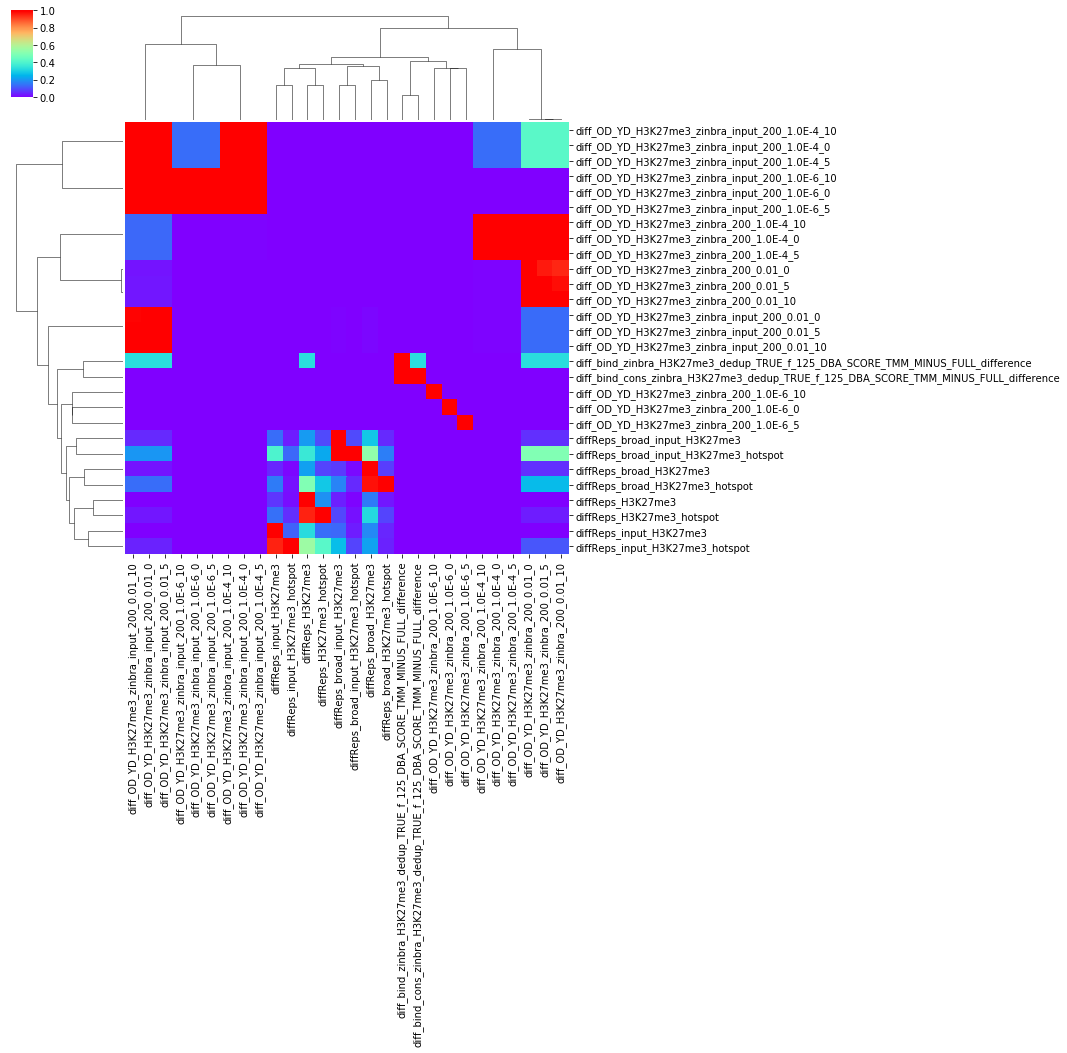

In [16]:
intersection = diffs.count_intersections()

do_plot("m1")

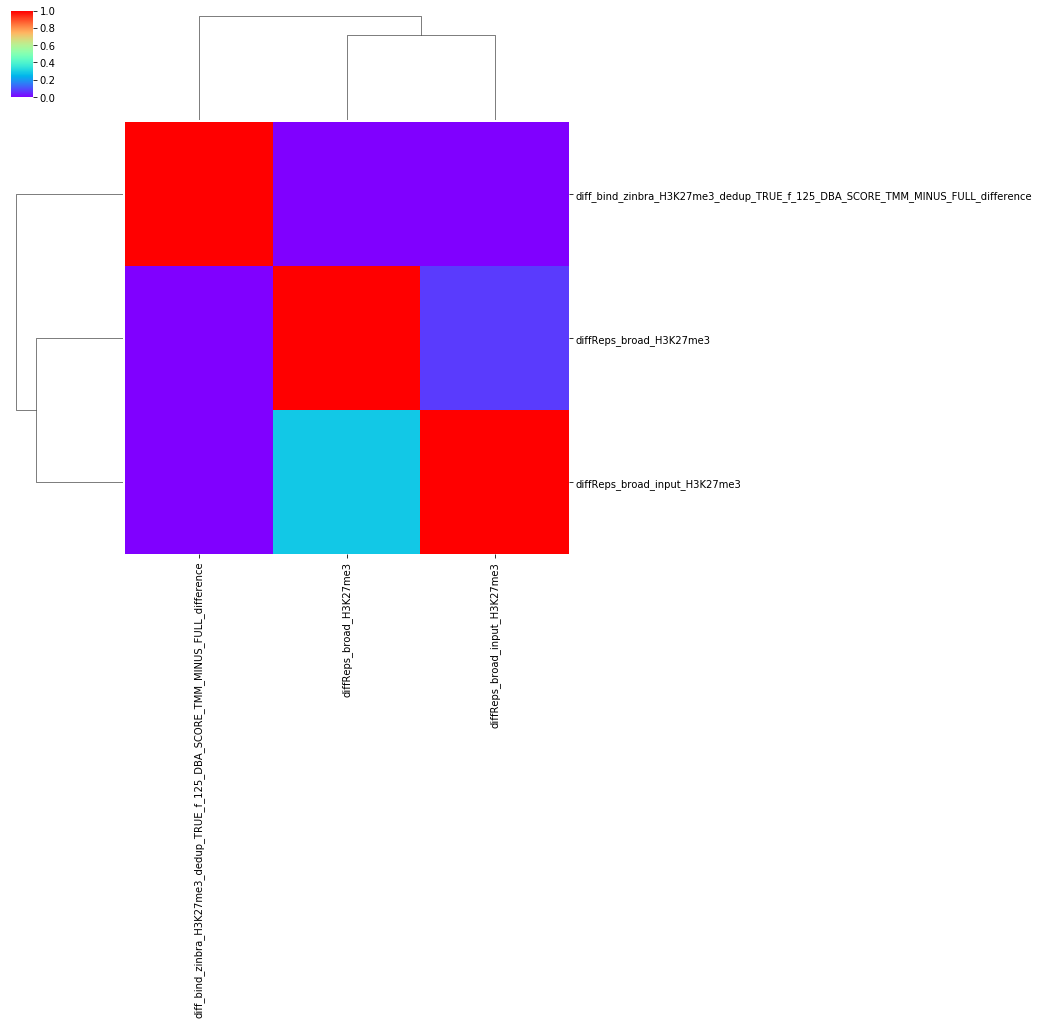

In [17]:
do_plot("m1", ['diff_bind_span_H3K27me3_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed',
               'diffReps_broad_H3K27me3_both.bed',
               'diffReps_broad_input_H3K27me3_both.bed'])


In [18]:
print_best("jaccard")

,f1,f2,score
0,diffReps_broad_H3K27me3_both.bed,diff_OD_YD_H3K27me3_span_input_200_0.01_10_b...,0.006124
1,diffReps_H3K27me3_both.bed,diff_bind_span_H3K27me3_dedup_TRUE_f_125_DBA...,0.000625
2,diff_bind_span_H3K27me3_dedup_TRUE_f_125_DBA...,diff_OD_YD_H3K27me3_span_input_200_0.01_10_b...,0.000257


In [19]:
print_best("m1")

,f1,f2,score
0,diffReps_broad_input_H3K27me3_hotspot_both.bed,diff_OD_YD_H3K27me3_span_200_0.01_0_both.bed,0.500000
1,diff_bind_span_H3K27me3_dedup_TRUE_f_125_DBA...,diffReps_H3K27me3_both.bed,0.333333
2,diff_bind_span_H3K27me3_dedup_TRUE_f_125_DBA...,diff_OD_YD_H3K27me3_span_200_0.01_0_both.bed,0.333333
3,diff_OD_YD_H3K27me3_span_input_200_0.01_10_b...,diffReps_broad_H3K27me3_both.bed,0.007971
4,diffReps_H3K27me3_both.bed,diff_bind_span_H3K27me3_dedup_TRUE_f_125_DBA...,0.000626
5,diff_OD_YD_H3K27me3_span_input_200_0.01_10_b...,diff_bind_span_H3K27me3_dedup_TRUE_f_125_DBA...,0.000257


bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27me3/both/diffReps_broad_H3K27me3_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K27me3/both/diffReps_broad_input_H3K27me3_both.bed >/tmp/tmpyvdzdn7w.tmp/counts.bed
0


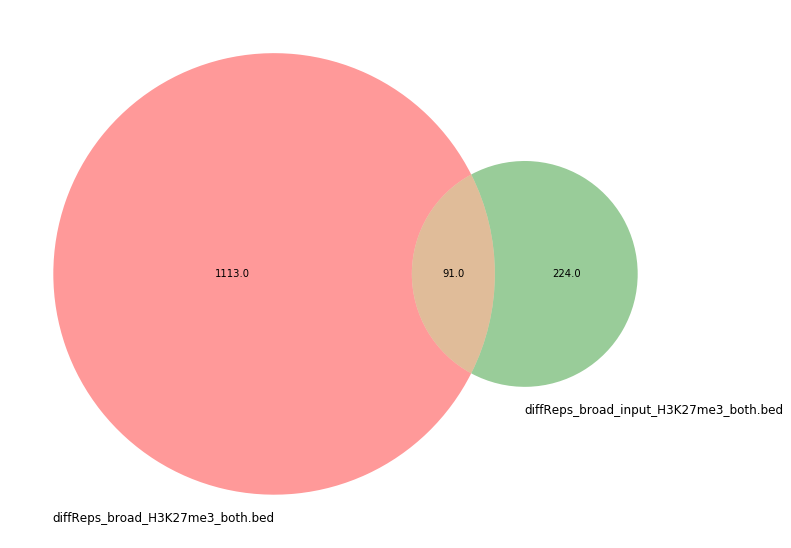

In [20]:
diffs.plot_venn2('diffReps_broad_H3K27me3_both.bed',
                 'diffReps_broad_input_H3K27me3_both.bed')

## H3K4me1

In [21]:
diffs = diffs_dict['H3K4me1']
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_span_H3K4me1_dedup_TRUE_f_125_DBA_...,2,0,2
1,diff_bind_cons_span_H3K4me1_dedup_TRUE_f_125...,2,0,2
2,chipdiff_H3K4me1,0,0,0
3,diff_OD_YD_H3K4me1_span_200_0.01_0,28879,13446,15433
4,diff_OD_YD_H3K4me1_span_200_0.01_5,27479,12727,14752
5,diff_OD_YD_H3K4me1_span_200_0.01_10,26656,12331,14325
6,diff_OD_YD_H3K4me1_span_200_1.0E-4_0,1894,883,1011
7,diff_OD_YD_H3K4me1_span_200_1.0E-4_5,1847,864,983
8,diff_OD_YD_H3K4me1_span_200_1.0E-4_10,1831,859,972
9,diff_OD_YD_H3K4me1_span_200_1.0E-6_0,96,41,55


/tmp/tmputvr3d5t.tmp


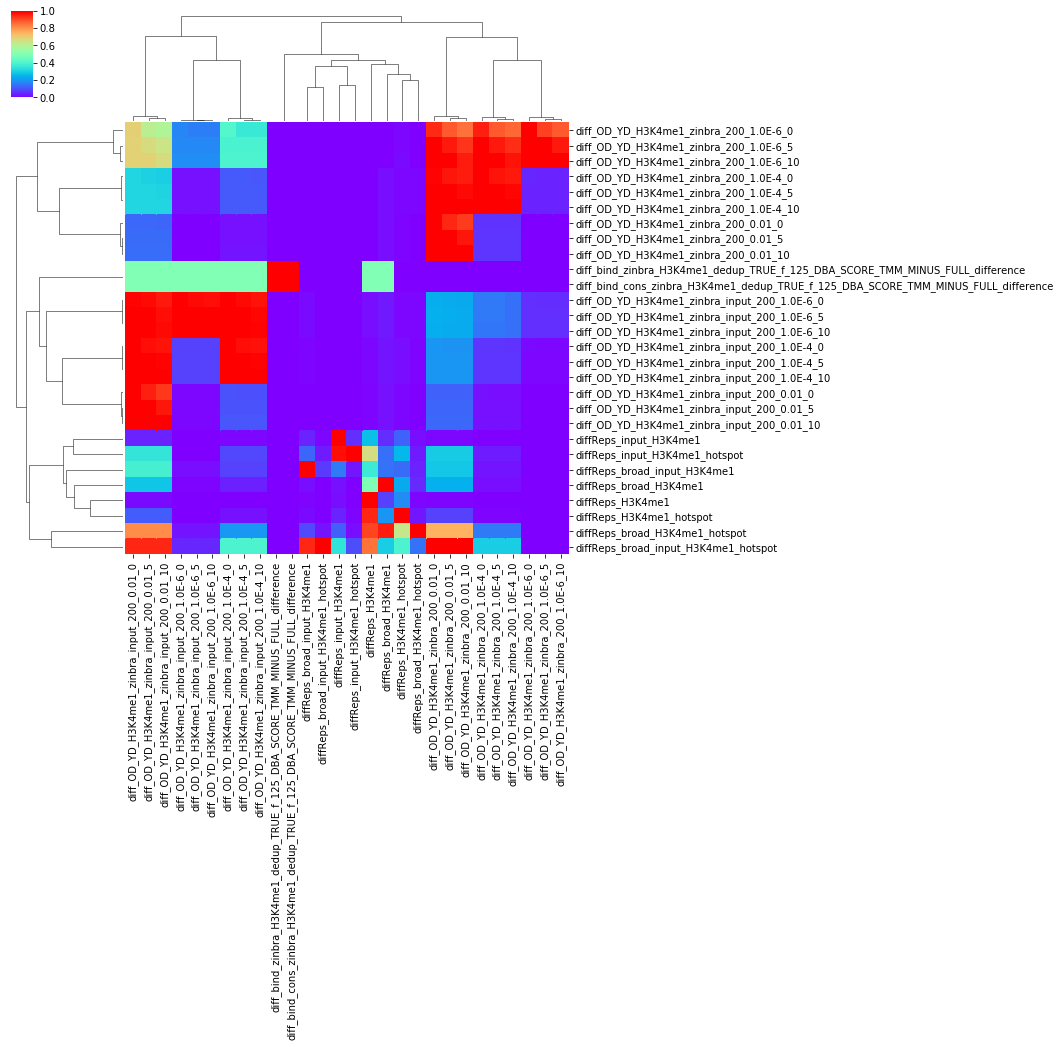

In [22]:
intersection = diffs.count_intersections()

do_plot("m1")

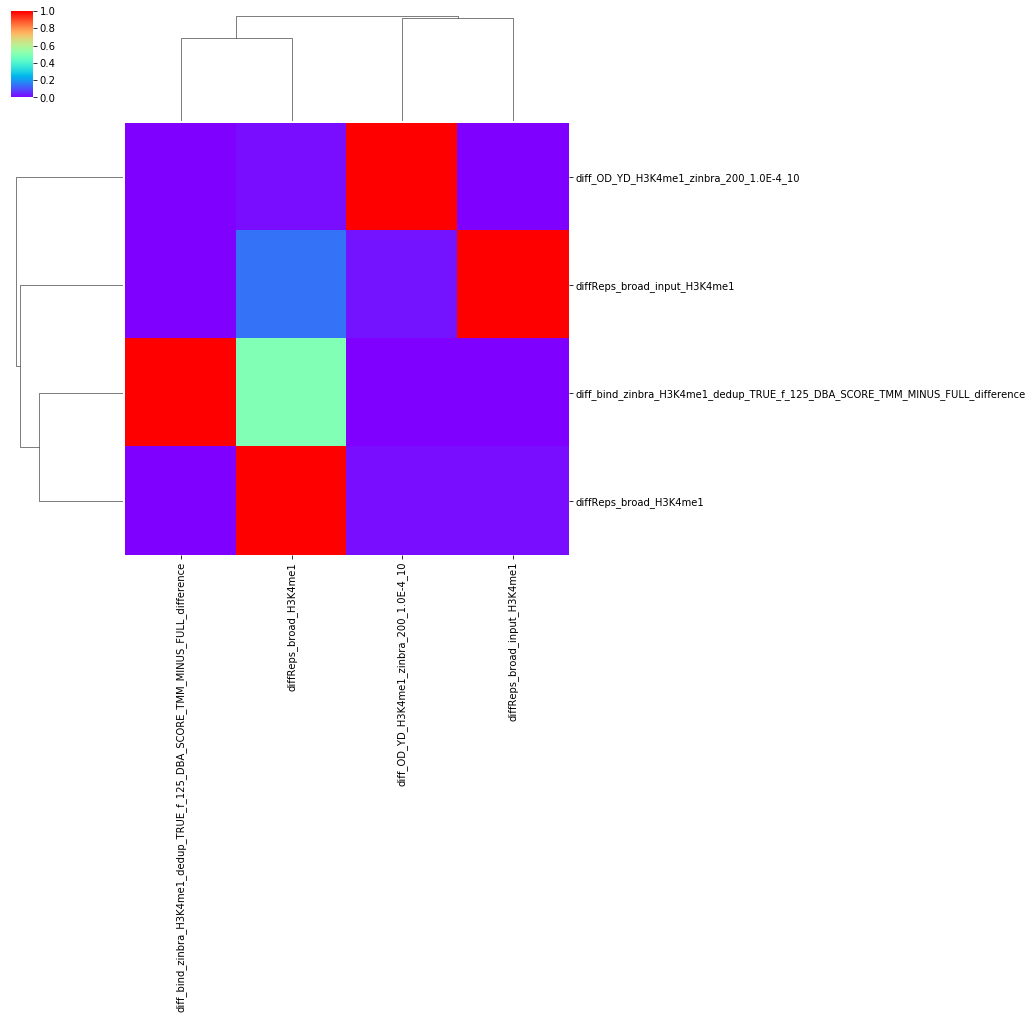

In [23]:
do_plot("m1", ['diff_bind_span_H3K4me1_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed',               
               'diff_OD_YD_H3K4me1_span_200_1.0E-4_10_both.bed',
               'diffReps_broad_H3K4me1_both.bed',
               'diffReps_broad_input_H3K4me1_both.bed'])

In [24]:
print_best("jaccard")

,f1,f2,score
0,diffReps_broad_H3K4me1_both.bed,diff_OD_YD_H3K4me1_span_input_200_0.01_10_bo...,0.020018
1,diff_bind_span_H3K4me1_dedup_TRUE_f_125_DBA_...,diff_OD_YD_H3K4me1_span_input_200_1.0E-6_10_...,0.003690
2,diffReps_broad_H3K4me1_both.bed,diff_bind_span_H3K4me1_dedup_TRUE_f_125_DBA_...,0.000479


In [25]:
print_best("m1")

,f1,f2,score
0,diffReps_broad_input_H3K4me1_hotspot_both.bed,diff_OD_YD_H3K4me1_span_200_0.01_0_both.bed,1.000000
1,diff_bind_span_H3K4me1_dedup_TRUE_f_125_DBA_...,diffReps_H3K4me1_both.bed,0.500000
2,diff_bind_span_H3K4me1_dedup_TRUE_f_125_DBA_...,diff_OD_YD_H3K4me1_span_input_200_0.01_0_bot...,0.500000
3,diff_OD_YD_H3K4me1_span_input_200_1.0E-6_10_...,diffReps_broad_H3K4me1_both.bed,0.033333
4,diff_OD_YD_H3K4me1_span_input_200_1.0E-6_10_...,diff_bind_span_H3K4me1_dedup_TRUE_f_125_DBA_...,0.003704
5,diffReps_broad_H3K4me1_both.bed,diff_bind_span_H3K4me1_dedup_TRUE_f_125_DBA_...,0.000479


In [26]:
diffs.get_bed_files_produced()

['diff_bind_span_H3K4me1_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed',
 'diff_bind_cons_span_H3K4me1_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed',
 'diff_OD_YD_H3K4me1_span_200_0.01_0_both.bed',
 'diff_OD_YD_H3K4me1_span_200_0.01_5_both.bed',
 'diff_OD_YD_H3K4me1_span_200_0.01_10_both.bed',
 'diff_OD_YD_H3K4me1_span_200_1.0E-4_0_both.bed',
 'diff_OD_YD_H3K4me1_span_200_1.0E-4_5_both.bed',
 'diff_OD_YD_H3K4me1_span_200_1.0E-4_10_both.bed',
 'diff_OD_YD_H3K4me1_span_200_1.0E-6_0_both.bed',
 'diff_OD_YD_H3K4me1_span_200_1.0E-6_5_both.bed',
 'diff_OD_YD_H3K4me1_span_200_1.0E-6_10_both.bed',
 'diff_OD_YD_H3K4me1_span_input_200_0.01_0_both.bed',
 'diff_OD_YD_H3K4me1_span_input_200_0.01_5_both.bed',
 'diff_OD_YD_H3K4me1_span_input_200_0.01_10_both.bed',
 'diff_OD_YD_H3K4me1_span_input_200_1.0E-4_0_both.bed',
 'diff_OD_YD_H3K4me1_span_input_200_1.0E-4_5_both.bed',
 'diff_OD_YD_H3K4me1_span_input_200_1.0E-4_10_both.bed',
 'diff_OD_YD_H3K4me1_span_input_200_1.

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K4me1/both/diffReps_broad_H3K4me1_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K4me1/both/diffReps_broad_input_H3K4me1_both.bed >/tmp/tmpm04h2422.tmp/counts.bed
0


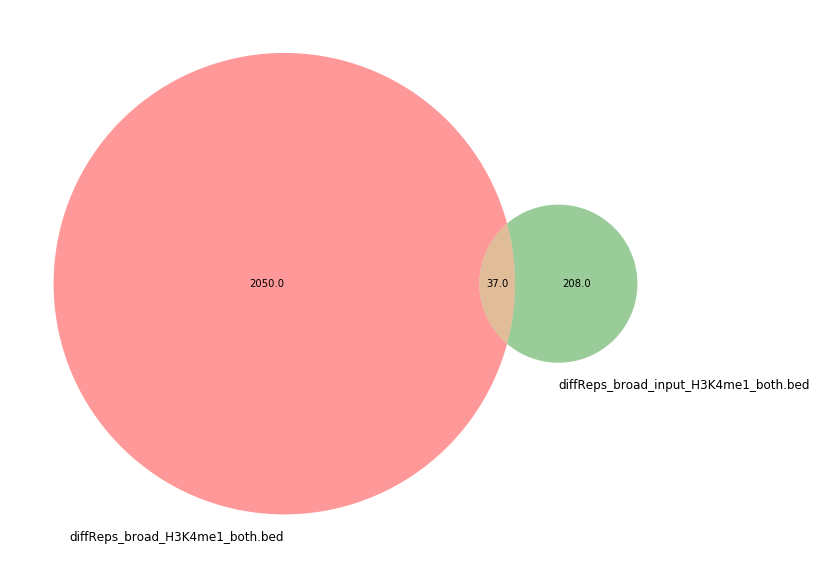

In [27]:
diffs.plot_venn2('diffReps_broad_H3K4me1_both.bed',
                 'diffReps_broad_input_H3K4me1_both.bed')

## H3K4me3

In [28]:
diffs = diffs_dict['H3K4me3']
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_span_H3K4me3_dedup_TRUE_f_125_DBA_...,3,2,1
1,diff_bind_cons_span_H3K4me3_dedup_TRUE_f_125...,5,5,0
2,chipdiff_H3K4me3,0,0,0
3,diff_OD_YD_H3K4me3_span_200_0.01_0,4112,3567,545
4,diff_OD_YD_H3K4me3_span_200_0.01_5,4097,3553,544
5,diff_OD_YD_H3K4me3_span_200_0.01_10,4089,3545,544
6,diff_OD_YD_H3K4me3_span_200_1.0E-4_0,3,3,0
7,diff_OD_YD_H3K4me3_span_200_1.0E-4_5,2,2,0
8,diff_OD_YD_H3K4me3_span_200_1.0E-4_10,1,1,0
9,diff_OD_YD_H3K4me3_span_200_1.0E-6_0,0,0,0


/tmp/tmp9pqzzy96.tmp


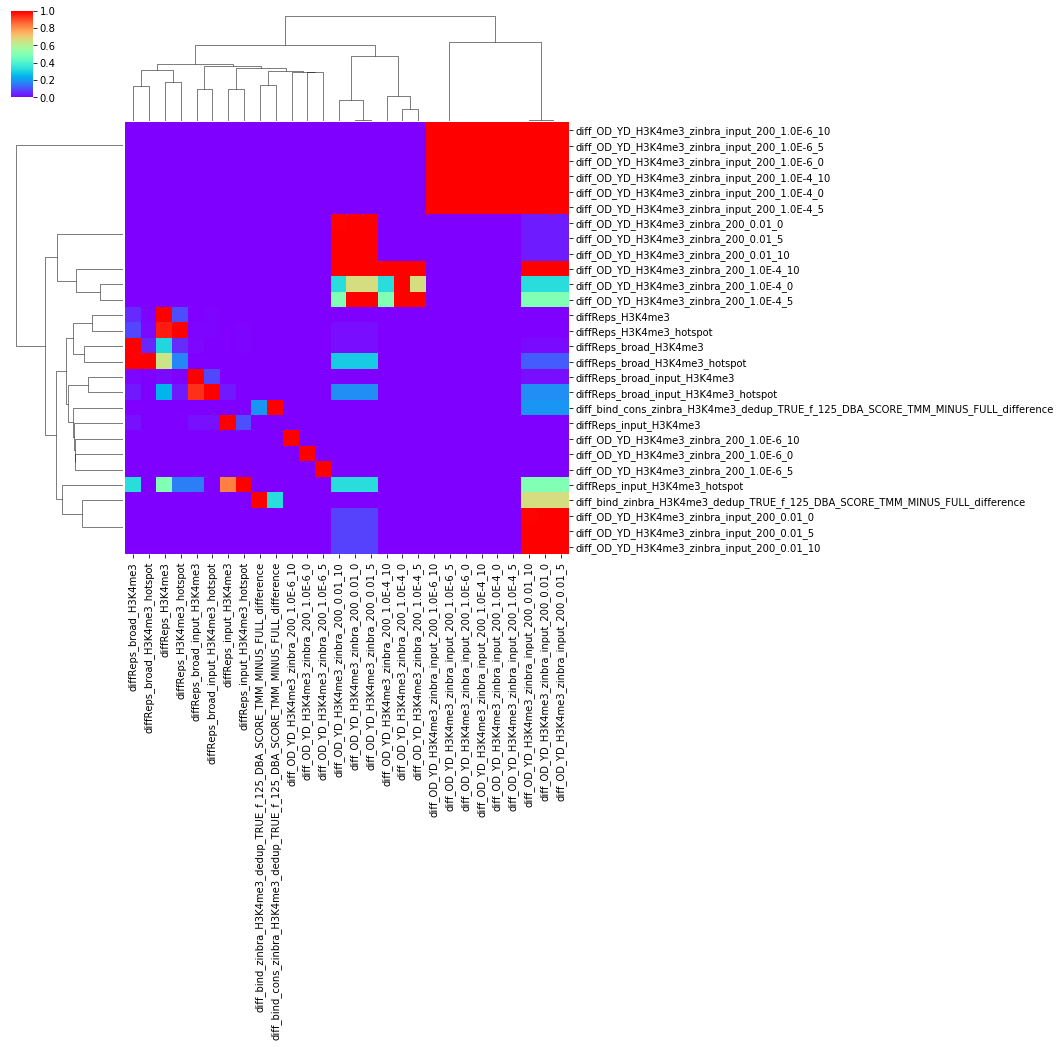

In [29]:
intersection = diffs.count_intersections()

do_plot("m1")

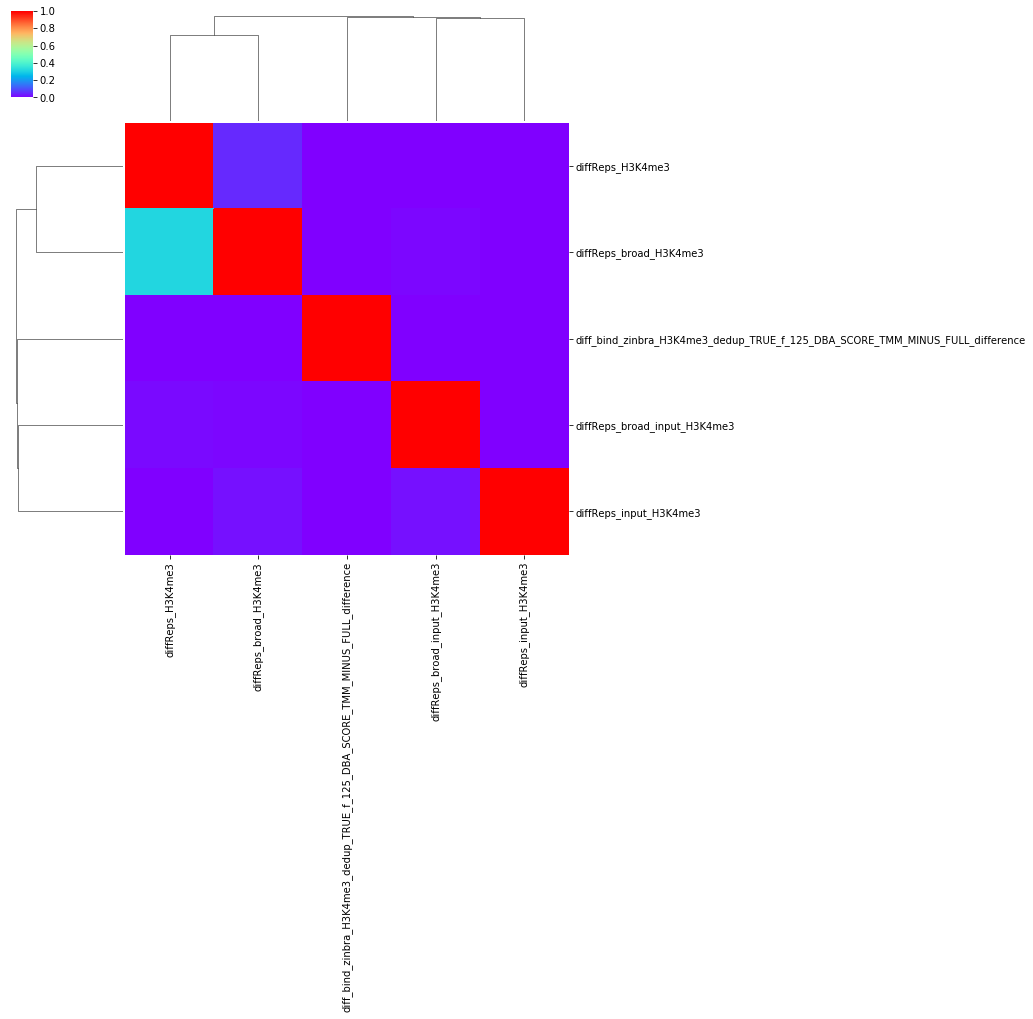

In [30]:
do_plot("m1", ['diff_bind_span_H3K4me3_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed',                        
               'diffReps_H3K4me3_both.bed',
               'diffReps_broad_H3K4me3_both.bed',
               'diffReps_broad_input_H3K4me3_both.bed',
               'diffReps_input_H3K4me3_both.bed'])

In [31]:
print_best("jaccard")

,f1,f2,score
0,diffReps_broad_input_H3K4me3_hotspot_both.bed,diff_OD_YD_H3K4me3_span_input_200_0.01_10_bo...,0.003478
1,diff_bind_span_H3K4me3_dedup_TRUE_f_125_DBA_...,diff_OD_YD_H3K4me3_span_input_200_0.01_10_bo...,0.001176
2,diffReps_H3K4me3_both.bed,diff_bind_span_H3K4me3_dedup_TRUE_f_125_DBA_...,0.000000


In [32]:
print_best("m1")

,f1,f2,score
0,diff_bind_span_H3K4me3_dedup_TRUE_f_125_DBA_...,diff_OD_YD_H3K4me3_span_input_200_0.01_0_bot...,0.666667
1,diffReps_input_H3K4me3_hotspot_both.bed,diff_OD_YD_H3K4me3_span_input_200_0.01_0_bot...,0.500000
2,diff_OD_YD_H3K4me3_span_input_200_0.01_10_bo...,diffReps_broad_input_H3K4me3_both.bed,0.003531
3,diff_OD_YD_H3K4me3_span_input_200_0.01_10_bo...,diff_bind_span_H3K4me3_dedup_TRUE_f_125_DBA_...,0.001177
4,diff_bind_span_H3K4me3_dedup_TRUE_f_125_DBA_...,diffReps_H3K4me3_both.bed,0.000000
5,diffReps_H3K4me3_both.bed,diff_bind_span_H3K4me3_dedup_TRUE_f_125_DBA_...,0.000000


In [33]:
diffs.get_bed_files_produced()

['diff_bind_span_H3K4me3_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed',
 'diff_bind_cons_span_H3K4me3_dedup_TRUE_f_125_DBA_SCORE_TMM_MINUS_FULL_difference_both.bed',
 'diff_OD_YD_H3K4me3_span_200_0.01_0_both.bed',
 'diff_OD_YD_H3K4me3_span_200_0.01_5_both.bed',
 'diff_OD_YD_H3K4me3_span_200_0.01_10_both.bed',
 'diff_OD_YD_H3K4me3_span_200_1.0E-4_0_both.bed',
 'diff_OD_YD_H3K4me3_span_200_1.0E-4_5_both.bed',
 'diff_OD_YD_H3K4me3_span_200_1.0E-4_10_both.bed',
 'diff_OD_YD_H3K4me3_span_200_1.0E-6_0_both.bed',
 'diff_OD_YD_H3K4me3_span_200_1.0E-6_5_both.bed',
 'diff_OD_YD_H3K4me3_span_200_1.0E-6_10_both.bed',
 'diff_OD_YD_H3K4me3_span_input_200_0.01_0_both.bed',
 'diff_OD_YD_H3K4me3_span_input_200_0.01_5_both.bed',
 'diff_OD_YD_H3K4me3_span_input_200_0.01_10_both.bed',
 'diff_OD_YD_H3K4me3_span_input_200_1.0E-4_0_both.bed',
 'diff_OD_YD_H3K4me3_span_input_200_1.0E-4_5_both.bed',
 'diff_OD_YD_H3K4me3_span_input_200_1.0E-4_10_both.bed',
 'diff_OD_YD_H3K4me3_span_input_200_1.

bash /home/atsky/work/washu/bed/union.sh /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K4me3/both/diffReps_broad_H3K4me3_both.bed /mnt/stripe/bio/experiments/configs/Y20O20/chip-seq-diff/processed/H3K4me3/both/diffReps_broad_input_H3K4me3_both.bed >/tmp/tmp3zw2kunu.tmp/counts.bed
0


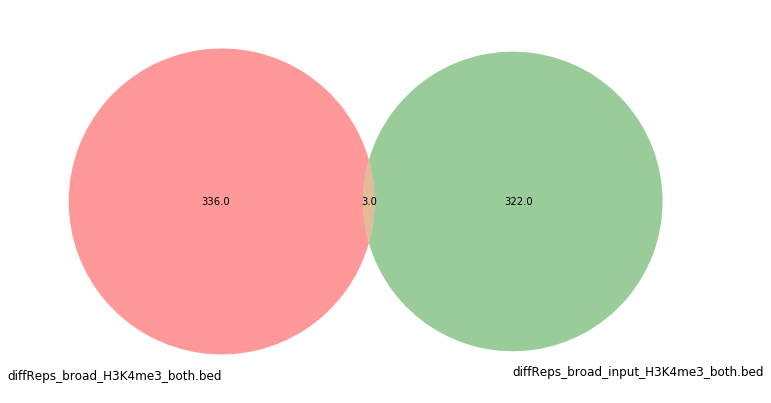

In [34]:
diffs.plot_venn2('diffReps_broad_H3K4me3_both.bed',
                 'diffReps_broad_input_H3K4me3_both.bed')

## H3K36me3

In [35]:
diffs = diffs_dict['H3K36me3']
pd.DataFrame.from_records(diffs.get_counts(), columns=["name", "both", "young", "old"])

,name,both,young,old
0,diff_bind_span_H3K36me3_dedup_TRUE_f_125_DBA...,0,0,0
1,diff_bind_cons_span_H3K36me3_dedup_TRUE_f_12...,0,0,0
2,chipdiff_H3K36me3,0,0,0
3,diff_OD_YD_H3K36me3_span_200_0.01_0,50474,7086,43388
4,diff_OD_YD_H3K36me3_span_200_0.01_5,47017,6639,40378
5,diff_OD_YD_H3K36me3_span_200_0.01_10,44304,6275,38029
6,diff_OD_YD_H3K36me3_span_200_1.0E-4_0,2444,214,2230
7,diff_OD_YD_H3K36me3_span_200_1.0E-4_5,2403,212,2191
8,diff_OD_YD_H3K36me3_span_200_1.0E-4_10,2379,212,2167
9,diff_OD_YD_H3K36me3_span_200_1.0E-6_0,64,1,63


/tmp/tmpua17a7g_.tmp


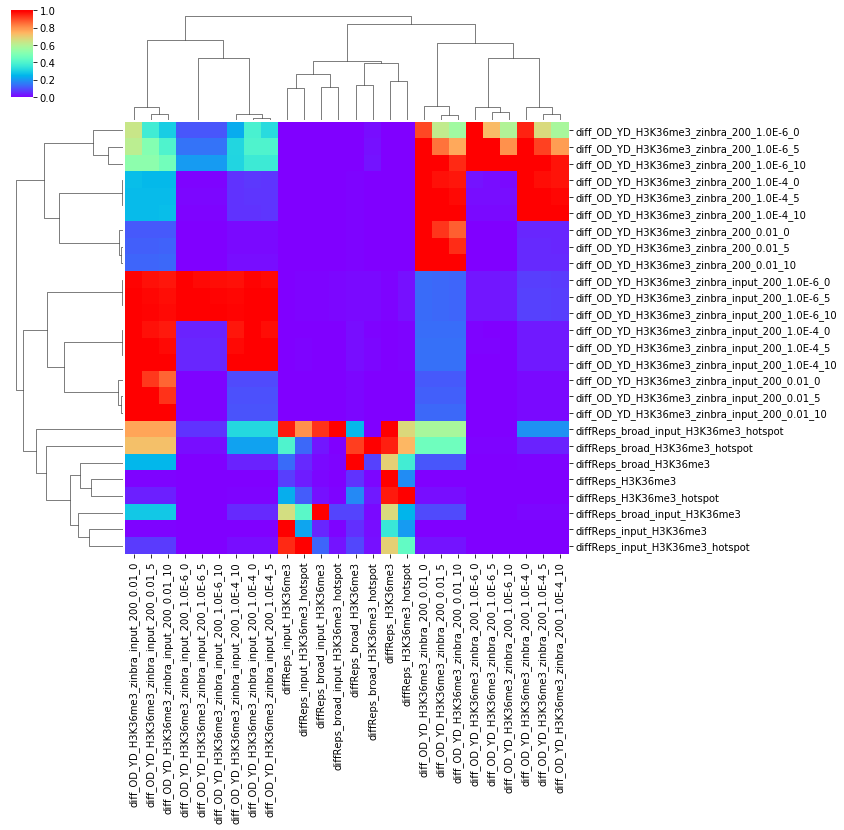

In [36]:
intersection = diffs.count_intersections()

do_plot("m1")

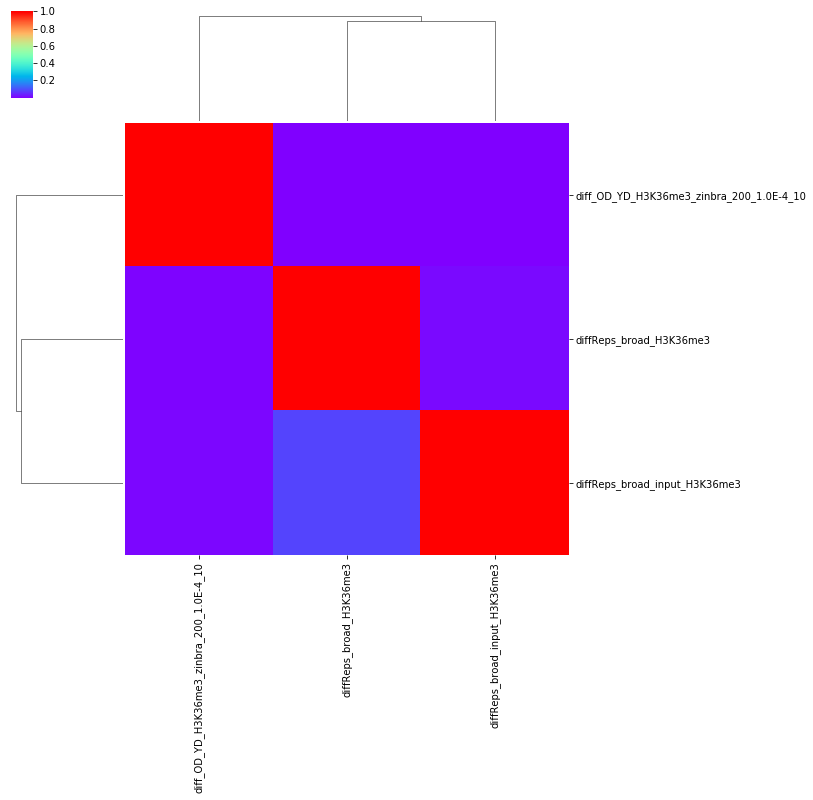

In [37]:
do_plot("m1", ['diff_OD_YD_H3K36me3_span_200_1.0E-4_10_both.bed',               
               'diffReps_broad_H3K36me3_both.bed',
               'diffReps_broad_input_H3K36me3_both.bed'])


In [38]:
print_best("jaccard")

,f1,f2,score
0,diffReps_broad_H3K36me3_both.bed,diff_OD_YD_H3K36me3_span_input_200_1.0E-4_10...,0.012402


In [39]:
print_best("m1")

,f1,f2,score
0,diffReps_broad_input_H3K36me3_hotspot_both.bed,diff_OD_YD_H3K36me3_span_input_200_0.01_0_bo...,0.774194
1,diff_OD_YD_H3K36me3_span_200_1.0E-6_10_both.bed,diffReps_broad_H3K36me3_hotspot_both.bed,0.026316


In [40]:
diffs.get_bed_files_produced()

['diff_OD_YD_H3K36me3_span_200_0.01_0_both.bed',
 'diff_OD_YD_H3K36me3_span_200_0.01_5_both.bed',
 'diff_OD_YD_H3K36me3_span_200_0.01_10_both.bed',
 'diff_OD_YD_H3K36me3_span_200_1.0E-4_0_both.bed',
 'diff_OD_YD_H3K36me3_span_200_1.0E-4_5_both.bed',
 'diff_OD_YD_H3K36me3_span_200_1.0E-4_10_both.bed',
 'diff_OD_YD_H3K36me3_span_200_1.0E-6_0_both.bed',
 'diff_OD_YD_H3K36me3_span_200_1.0E-6_5_both.bed',
 'diff_OD_YD_H3K36me3_span_200_1.0E-6_10_both.bed',
 'diff_OD_YD_H3K36me3_span_input_200_0.01_0_both.bed',
 'diff_OD_YD_H3K36me3_span_input_200_0.01_5_both.bed',
 'diff_OD_YD_H3K36me3_span_input_200_0.01_10_both.bed',
 'diff_OD_YD_H3K36me3_span_input_200_1.0E-4_0_both.bed',
 'diff_OD_YD_H3K36me3_span_input_200_1.0E-4_5_both.bed',
 'diff_OD_YD_H3K36me3_span_input_200_1.0E-4_10_both.bed',
 'diff_OD_YD_H3K36me3_span_input_200_1.0E-6_0_both.bed',
 'diff_OD_YD_H3K36me3_span_input_200_1.0E-6_5_both.bed',
 'diff_OD_YD_H3K36me3_span_input_200_1.0E-6_10_both.bed',
 'diffReps_H3K36me3_both.bed',
 'd